# **Spaceship Titanic**

The task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. More details here: https://www.kaggle.com/competitions/spaceship-titanic/overview

# **0. Nescessary Imports**

This cell imports all the necessary libraries and modules used in the project:

- **Data Manipulation and Analysis**: 
  - `pandas` and `numpy` are used for handling and manipulating datasets efficiently.
  
- **Data Preprocessing and Model Evaluation**: 
  - `StandardScaler` and `MinMaxScaler` from `sklearn.preprocessing` for feature scaling.
  - `train_test_split` for splitting the dataset into training and testing subsets.
  - `GridSearchCV` for performing hyperparameter tuning.

- **Machine Learning Models**: 
  - `LogisticRegression`, `MLPClassifier`, `GradientBoostingClassifier`, and `RandomForestClassifier` for building and evaluating various models.

- **Model Performance Metrics**:
  - Metrics such as accuracy, F1 score, recall, precision, and confusion matrix are imported for model evaluation.
  - `permutation_importance` to assess feature importance for tree-based models.

- **Visualization and Display**:
  - `ConfusionMatrixDisplay` for visualizing model performance.
  - `matplotlib.pyplot` and `seaborn` for creating plots and heatmaps.
  - `IPython.display` for formatting and displaying Markdown outputs.


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from sklearn.inspection import permutation_importance

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sb

# **1. Data Preparation**

1. **Feature Engineering**:
   - **PassengerId**: The `PassengerId` feature was considered irrelevant for prediction as it provided no direct information on whether a passenger was transported. However, it contained group-related information, which was useful for analysis. Hence, `PassengerId` was split into two new features: `PassengerGroup` (representing the group the passenger is traveling with) and `PassengerNumber` (indicating the individual within the group). After extracting this useful information, the original `PassengerId` feature was dropped.
   - **Cabin**: The `Cabin` feature, which contains the format `deck/num/side`, was split into three separate features: `Deck`, `Num`, and `Side`. While `Num` didn’t contribute meaningfully, both `Deck` and `Side` were retained. These features might affect the likelihood of a passenger being transported, as different locations on the ship could influence their behavior in the scenario being studied.

2. **Missing Data Imputation**:
   - **VIP**: For the `VIP` feature, missing values were imputed based on the analysis of service expenses *(**Fig 1**)*. VIP passengers typically spent more on services, so the missing values were filled based on the mean service usage of VIP passengers. Additionally, passengers with service expenditures higher than the average VIP were classified as VIP, while those with lower expenditures were marked as non-VIP.
   - **CryoSleep**: Passengers in CryoSleep do not use onboard services. Therefore, any missing values in `CryoSleep` were imputed as `True`, while passengers with recorded service usage had their `CryoSleep` status set to `False`.
   - **Service Features**: For the service-related columns (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`), missing values were imputed based on the mean service usage for VIP and non-VIP passengers. CryoSleep passengers had their service expenditures set to zero, as they would not be using these services.
   - **HomePlanet**: Based on observations *(**Fig 2**)*, non-VIP passengers were mostly from Earth, while VIP passengers were from Europa. Thus, missing values in the `HomePlanet` feature were filled with `Earth` for non-VIP passengers and `Europa` for VIP passengers.
   - **Deck**: The `Deck` feature showed patterns based on the passenger's `HomePlanet` *(**Fig 3**)*. For Earth-origin passengers, the deck was mostly `G`, and for Mars-origin passengers, it was typically `F`. Missing values for `Deck` were filled based on these patterns, while Europa-origin passengers, who lacked a clear deck association, had their missing values imputed with a probable deck value.
   - **Side and Destination**: The `Side` feature was symmetric and did not show any significant trends, so missing values were filled with the most frequent value (mode). Similarly, the `Destination` feature had no clear relationships with other features, so its missing values were also filled with the mode.
   - **Age**: The `Age` feature had missing values that were imputed with the mean age, as the distribution of age was roughly normal, making the mean a reasonable choice for imputation.

3. **Data Types and Categorical Features**:
   - After handling the missing values, the data types of binary features like `Side` and `CryoSleep` were adjusted to boolean types, which are more efficient for machine learning models.
   - Categorical features, such as `HomePlanet`, `Destination`, and `Deck`, were one-hot encoded, creating binary columns for each category to ensure the data could be processed by machine learning models.

4. **Feature Correlations**

   At the end, checking for highly correlated features allows us to avoid redundant information *(**Fig 4**)*. Removing one of the correlated features helps simplify the model and improve its performance. None were found in our case.

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,
False,217.218527,426.336536,173.876298,301.711045,282.718056
True,473.615385,1811.393782,247.726804,760.710660,1234.856410


*Fig 1. Service mean values for `VIP` and `non-VIP`*

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,
False,350.146772,713.004316,270.586504,486.09294,475.716165
True,0.000000,0.000000,0.000000,0.00000,0.000000


*Fig 1. Service mean values for `CryoSleep`*

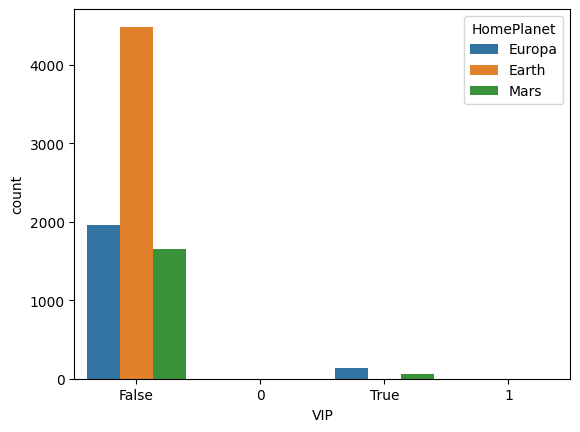

*Fig 2. Relation between `HomePlanet` and `VIP`*

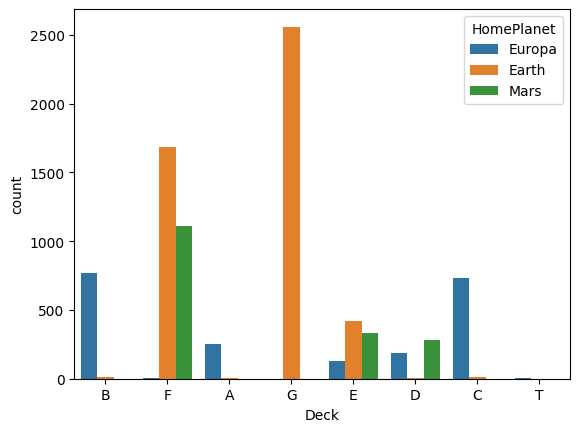

*Fig 3. Relation between `Deck` and `VIP`*

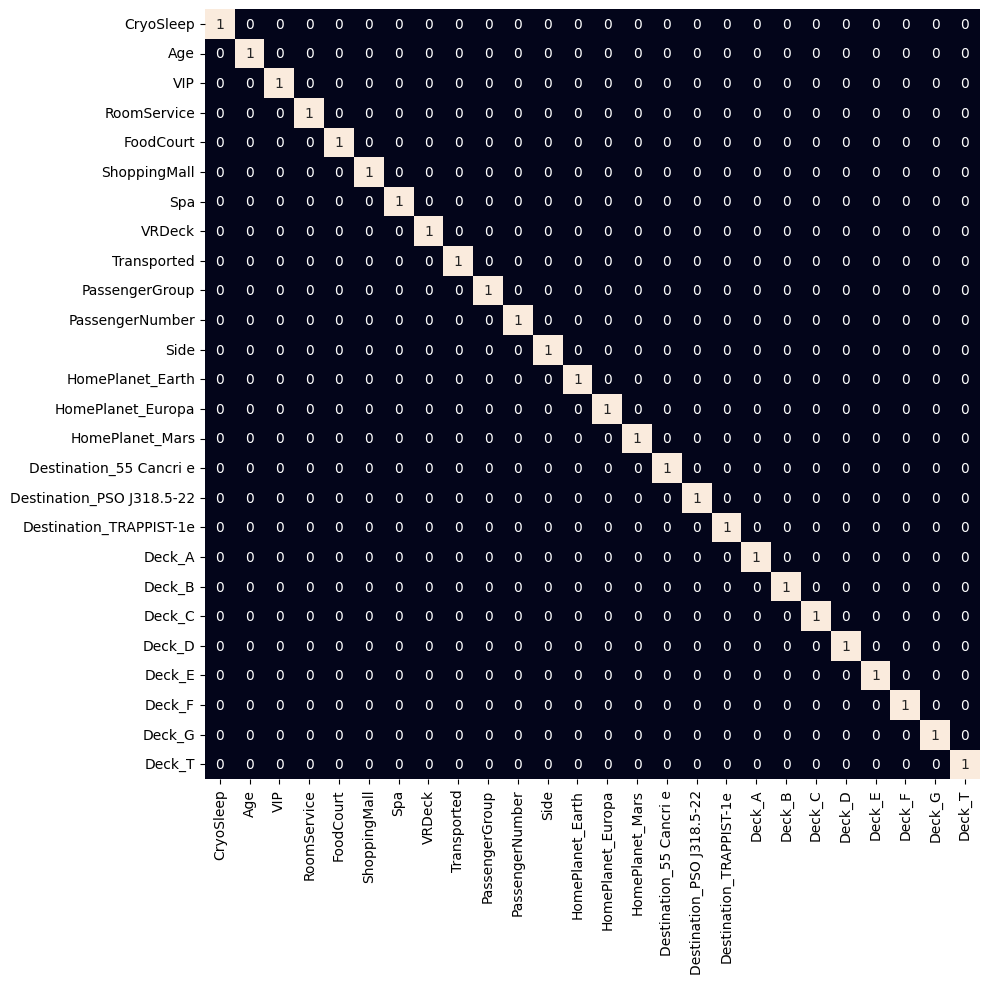

*Fig 4. Correlations between features*

In [14]:
# Load train DataSet
titanic_train_df = pd.read_csv('train.csv')

# Drop Name
titanic_train_df = titanic_train_df.drop(columns=['Name'])

# Make PassengerId relevant
titanic_train_df[['PassengerGroup', 'PassengerNumber']] = titanic_train_df["PassengerId"].str.split("_", n=1, expand=True)
titanic_train_df = titanic_train_df.drop(columns=['PassengerId'])

# Make Cabin relevant
titanic_train_df[['Deck', 'Num', 'Side']] = titanic_train_df['Cabin'].str.split('/', expand=True)
titanic_train_df = titanic_train_df.drop(columns=['Cabin', 'Num'])

# Fill VIP
service_column = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

display(titanic_train_df.groupby('VIP')[service_column].mean())
display(Markdown('*Fig 1. Service mean values for `VIP` and `non-VIP`*'))

vip_mean = titanic_train_df[titanic_train_df['VIP'] == 1][service_column].mean()
service_condition = (titanic_train_df[service_column] > vip_mean).sum(axis=1)
titanic_train_df.loc[titanic_train_df['VIP'].isnull(), 'VIP'] = np.where(service_condition[titanic_train_df['VIP'].isnull()] > 2, 1, 0)

# Fill CryoSleep
display(titanic_train_df.groupby('CryoSleep')[service_column].mean())
display(Markdown('*Fig 1. Service mean values for `CryoSleep`*'))

is_cryo = (titanic_train_df[service_column] == 0).all(axis=1)
titanic_train_df.loc[is_cryo, 'CryoSleep'] = True
titanic_train_df.loc[~is_cryo, 'CryoSleep'] = False

# Fill services
for column in service_column:
    for boolean in [True, False]:
        is_vip = titanic_train_df['VIP'] == boolean
        mean = titanic_train_df.loc[is_vip, column].mean().astype(float)
        titanic_train_df.loc[is_vip, column] = titanic_train_df.loc[is_vip, column].fillna(mean)
titanic_train_df.loc[titanic_train_df['CryoSleep'] == True, service_column] = 0.0

# Fill HomePlanet
sb.countplot(data=titanic_train_df, x='VIP', hue='HomePlanet')
plt.show()
display(Markdown('*Fig 2. Relation between `HomePlanet` and `VIP`*'))

is_vip = (titanic_train_df['VIP'] == True)
titanic_train_df.loc[titanic_train_df['HomePlanet'].isnull() & is_vip, 'HomePlanet'] = 'Europa'
titanic_train_df.loc[titanic_train_df['HomePlanet'].isnull() & ~is_vip, 'HomePlanet'] = 'Earth'

# Fill Deck
sb.countplot(data=titanic_train_df, x='Deck', hue='HomePlanet')
plt.show()
display(Markdown('*Fig 3. Relation between `Deck` and `VIP`*'))

titanic_train_df.loc[(titanic_train_df['HomePlanet'] == 'Earth') & (titanic_train_df['Deck'].isnull()), 'Deck'] = 'G'
titanic_train_df.loc[(titanic_train_df['HomePlanet'] == 'Mars') & (titanic_train_df['Deck'].isnull()), 'Deck'] = 'F'
titanic_train_df.loc[(titanic_train_df['HomePlanet'] == 'Europa') & (titanic_train_df['Deck'].isnull()), 'Deck'] = 'C'

# Fill Side
titanic_train_df['Side'] = titanic_train_df['Side'].fillna(titanic_train_df['Side'].mode()[0])

# Fill Destination
titanic_train_df['Destination'] = titanic_train_df['Destination'].fillna(titanic_train_df['Destination'].mode()[0])

# Fill Age
titanic_train_df['Age'] = titanic_train_df['Age'].fillna(titanic_train_df['Age'].mean())

# Manage column types and Encoding Categorical Variable
titanic_train_df['PassengerGroup'] = titanic_train_df['PassengerGroup'].astype(int)
titanic_train_df['PassengerNumber'] = titanic_train_df['PassengerNumber'].astype(int)
titanic_train_df['VIP'] = titanic_train_df['VIP'].astype(bool)
titanic_train_df['CryoSleep'] = titanic_train_df['CryoSleep'].astype(bool)
titanic_train_df.loc[titanic_train_df['Side']=='P','Side']=0
titanic_train_df.loc[titanic_train_df['Side']=='S','Side']=1
titanic_train_df['Side'] = titanic_train_df['Side'].astype(bool)
titanic_train_df = pd.get_dummies(titanic_train_df, columns=['HomePlanet', 'Destination', 'Deck'])

plt.figure(figsize=(10,10))
sb.heatmap(titanic_train_df.corr()>0.8, annot=True, cbar=False)
plt.show()
display(Markdown('*Fig 4. Correlations between features*'))

# **2. Fitting the Models and Classification**

### Model Training and Evaluation

This cell trains and evaluates multiple machine learning models with hyperparameter tuning using grid search. The steps are as follows:

1. **Data Splitting**:
   - Split the dataset into training and validation sets with an 80/20 split ratio.
   - `X_train` and `X_test` contain the features, while `y_train` and `y_test` contain the target (`Transported`).

2. **Model and Hyperparameter Setup**:
   - Defined a dictionary of models to test (`LogisticRegression`, `MLPClassifier`, `GradientBoostingClassifier`, `RandomForestClassifier`).
   - Configured corresponding hyperparameter grids for models that benefit from tuning (e.g., hidden layer sizes for `MLPClassifier`, learning rates and estimators for `GradientBoostingClassifier`).

3. **Scaler Comparison**:
   - Defined two scalers (`StandardScaler`, `MinMaxScaler`) to normalize features.
   - Normalized training and test sets using each scaler in turn.

4. **Grid Search for Hyperparameter Optimization**:
   - Performed a grid search with 5-fold cross-validation to identify the best hyperparameters for each model.
   - Used `accuracy` as the evaluation metric for grid search.
   - Stored the best model for each algorithm after the grid search.

5. **Prediction and Evaluation**:
   - Predicted on the validation set (`X_test_scaled`) using the best model from each algorithm.
   - Computed evaluation metrics: accuracy, F1 score, recall, and precision for each model.
   - Displayed a confusion matrix to visualize the performance of each model.

6. **Visualization and Results**:
   - Outputted the best hyperparameters and performance metrics for each model under each scaler.
   - Displayed confusion matrices for each combination of model and scaler.


Using StandardScaler
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LogisticRegression - Best Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}**

Accuracy: 0.7832
F1 Score: 0.7950
Recall: 0.8345
Precision: 0.7591


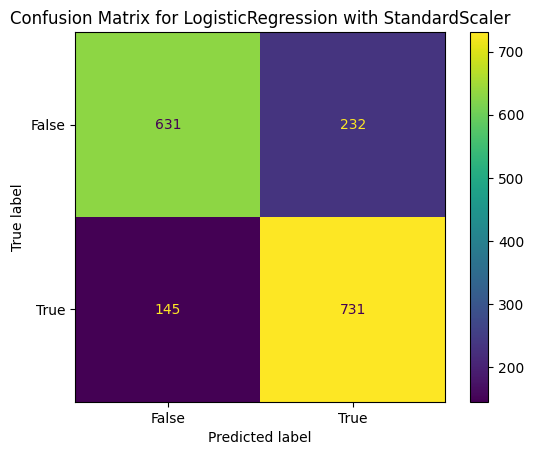

**MLPClassifier - Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.0001), 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}**

Accuracy: 0.8016
F1 Score: 0.8056
Recall: 0.8162
Precision: 0.7953


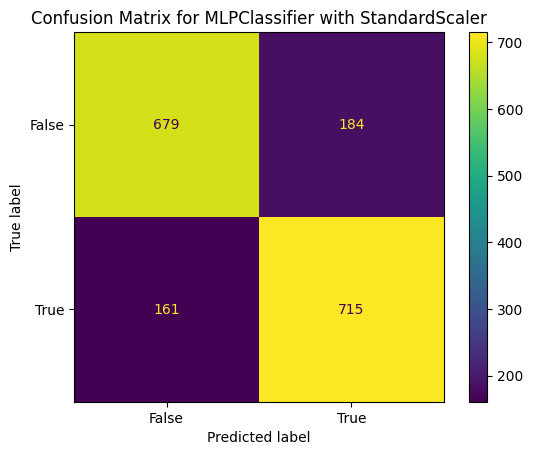

**GradientBoostingClassifier - Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': np.float64(0.1), 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': np.int64(300), 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}**

Accuracy: 0.8022
F1 Score: 0.8076
Recall: 0.8242
Precision: 0.7917


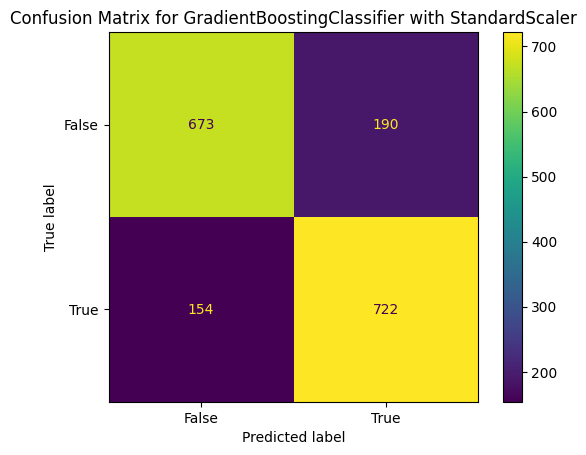

**RandomForestClassifier - Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}**

Accuracy: 0.8079
F1 Score: 0.8051
Recall: 0.7877
Precision: 0.8234


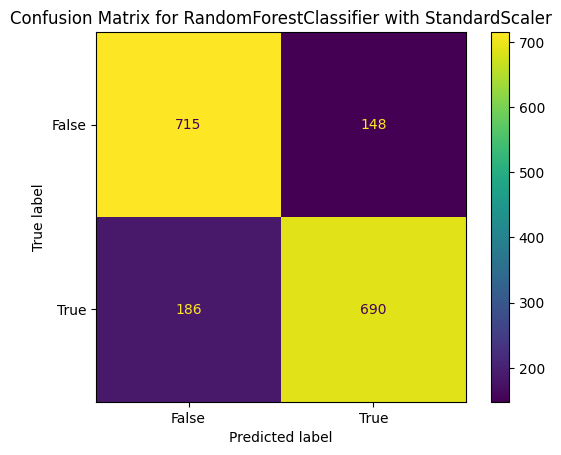

Using MinMaxScaler
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


**LogisticRegression - Best Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}**

Accuracy: 0.7579
F1 Score: 0.7493
Recall: 0.7180
Precision: 0.7833


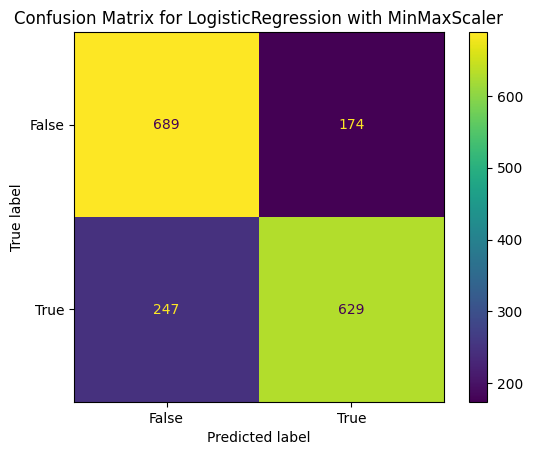

**MLPClassifier - Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.001), 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}**

Accuracy: 0.8022
F1 Score: 0.8030
Recall: 0.8002
Precision: 0.8057


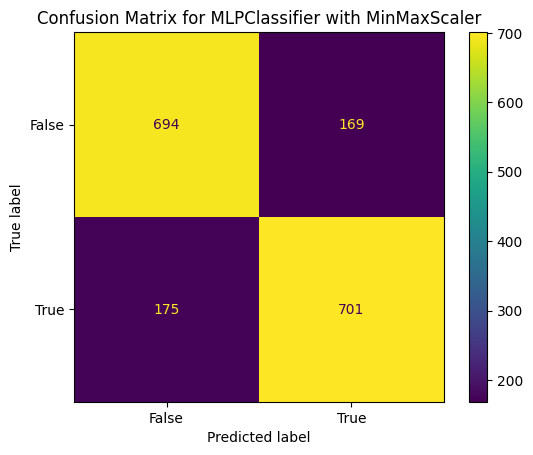

**GradientBoostingClassifier - Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': np.float64(0.1), 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': np.int64(300), 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}**

Accuracy: 0.8022
F1 Score: 0.8076
Recall: 0.8242
Precision: 0.7917


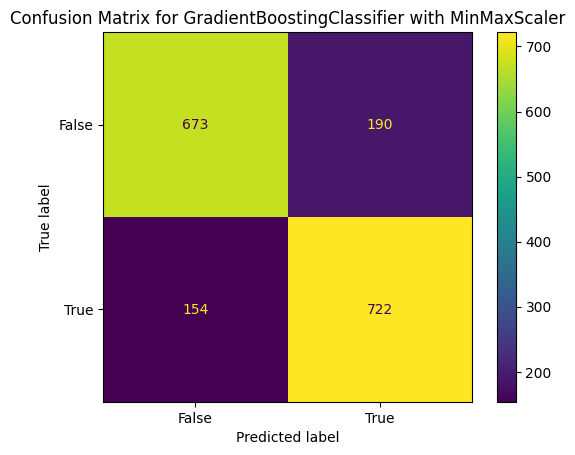

**RandomForestClassifier - Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}**

Accuracy: 0.8062
F1 Score: 0.8030
Recall: 0.7842
Precision: 0.8228


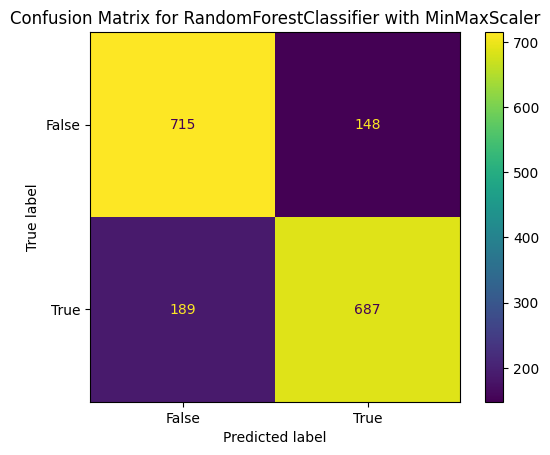

In [3]:
# Split into train and validation
features = titanic_train_df.drop(['Transported'], axis=1)
target = titanic_train_df['Transported']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# List of models and parameters
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=0),
    "MLPClassifier": MLPClassifier(max_iter=2000, random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0)
}

# List of parameter grids
models_param_grids = {
    "LogisticRegression": {},
    "MLPClassifier": {
        "hidden_layer_sizes": [(10, 10), (50, 50), (100,)],
        "learning_rate_init": np.logspace(-5, 0, 6)
    },
    "GradientBoostingClassifier": {
        "n_estimators": np.arange(50, 301, 50),
        "learning_rate": np.logspace(-5, 0, 6),
    },
    "RandomForestClassifier": {
        #"n_estimators": np.arange(50, 301, 50),
        #"max_depth": [None, 10, 20, 30],
        #"min_samples_split": np.arange(2, 11, 2)
    }
}

# Define the scalers you want to test
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler()
}

# Loop over each scaler
for scaler_name, scaler in scalers.items():
    print(f"Using {scaler_name}")
    
    # Normalize train and test data using the current scaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Loop over each model and perform grid search
    best_models = {}
    predictions_dict = {}
    for model_name, model in models.items():
        param_grid = models_param_grids[model_name]
        
        # Run GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
        
        # Retrieve the best model
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        # Make predictions with the best model
        prediction = best_model.predict(X_test_scaled)
        predictions_dict[model_name] = prediction

    # Evaluate the best models
    for model_name, prediction in predictions_dict.items():
        display(Markdown(f'**{model_name} - Best Parameters: {best_models[model_name].get_params()}**'))
        print(f"Accuracy: {accuracy_score(y_test, prediction):.4f}")
        print(f"F1 Score: {f1_score(y_test, prediction):.4f}")
        print(f"Recall: {recall_score(y_test, prediction):.4f}")
        print(f"Precision: {precision_score(y_test, prediction):.4f}")
        ConfusionMatrixDisplay.from_predictions(y_test, prediction)
        plt.title(f"Confusion Matrix for {model_name} with {scaler_name}")
        plt.show()